# Day 213,216,220,day 222,day 224,day 227,day 229

# now we are going to work with all 101 food classes instead of 10 classes that we have used so far to trian our model

* we want to beat the original paper on which was used this food 101. they used random forest model to get an accuracy of 50.76%. we will beat it!!!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import requests
import os
import tensorflow as tf
import zipfile
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.image as image
from mlxtend.plotting import plot_confusion_matrix

# helper_functions

In [2]:
if Path('helper_functions.py').is_file():
  print('Already Downloaded')
else:
  print('Downloading the helper functions of Mrdbourke')
  request = requests.get('https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py').content
  with open('helper_functions.py','wb') as f:
    f.write(request)

# getting the data ready!

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

zip = zipfile.ZipFile('101_food_classes_10_percent.zip')
zip.extractall()
zip.close()

--2023-11-08 12:24:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   232MB/s    in 11s     

2023-11-08 12:24:48 (143 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=(224,224),
                                                         batch_size=32,
                                                         label_mode='int',
                                                         )

test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=(224,224),
                                                        batch_size=32,
                                                        label_mode='int',
                                                        shuffle=False)



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# creating model checkpoint

In [5]:
path = 'checkpoints'
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(path,
                                                     monitor='val_accuracy',
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                    )

# creating a data augmentation layers

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# creating the feature extractor without the top(its own output layers)

* we remove the top because our custom outputs may have different number of classes than the ones the base_model was trained on.

In [7]:
# base_model
base = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base.trainable = False # freeze the whole model

input_layer = tf.keras.Input(shape=(224,224,3),name='input_layer')

# preprocessing the input_layer
x = data_augmentation(input_layer)

# putting the preprocesses layer into the feature_extractor(base), and making it untrainable
x = base(x,training=False)

# Global Average Pooling 2D layer
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)

# creating the output layer
output_layer = tf.keras.layers.Dense(len(train_data.class_names),activation='softmax',name='output_layer')(x)

# creating our feature_extractor model
model0 = tf.keras.Model(input_layer,output_layer)

24274472/24274472 [==============================] - 0s 0us/step


# # compile the model and fit the model

In [8]:
# compile the model
model0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# fit the model
feature_extractor_epochs = 5

model0.fit(train_data,
           epochs=feature_extractor_epochs,
           steps_per_epoch = len(train_data),
           validation_data=test_data,
           validation_steps=int(0.15*len(test_data)),
           callbacks=[ModelCheckpoint])

Epoch 1/5
237/237 [==============================] - 46s 123ms/step - loss: 3.5253 - accuracy: 0.2384 - val_loss: 2.7529 - val_accuracy: 0.3877
Epoch 2/5
237/237 [==============================] - 28s 115ms/step - loss: 2.4481 - accuracy: 0.4391 - val_loss: 2.2401 - val_accuracy: 0.4735
Epoch 3/5
237/237 [==============================] - 29s 122ms/step - loss: 2.0573 - accuracy: 0.5075 - val_loss: 2.0424 - val_accuracy: 0.5024
Epoch 4/5
237/237 [==============================] - 28s 116ms/step - loss: 1.8391 - accuracy: 0.5578 - val_loss: 1.9521 - val_accuracy: 0.5122
Epoch 5/5
237/237 [==============================] - 29s 121ms/step - loss: 1.6887 - accuracy: 0.5876 - val_loss: 1.8629 - val_accuracy: 0.5283


# fine-tuning the model

In [9]:
# unfreeze all the layers in the base model(make all the layers trainable)
base.trainable = True

# refreeze all the layers leaving only 5 layers at the end unfrozen
for layer in base.layers[:-5]:
  layer.trainable = False


# recompile the model and reduce learning rate by 10x
model0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

# fitting the model
total_epochs = feature_extractor_epochs + 5

history0 = model0.fit(train_data,
                      epochs=total_epochs,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)), # only testing 25% of the data
                      initial_epoch=5,
                      callbacks=[ModelCheckpoint])

Epoch 6/10
237/237 [==============================] - 40s 128ms/step - loss: 1.4721 - accuracy: 0.6329 - val_loss: 1.7646 - val_accuracy: 0.5373
Epoch 7/10
237/237 [==============================] - 29s 119ms/step - loss: 1.3863 - accuracy: 0.6438 - val_loss: 1.7270 - val_accuracy: 0.5434
Epoch 8/10
237/237 [==============================] - 25s 104ms/step - loss: 1.3178 - accuracy: 0.6543 - val_loss: 1.7416 - val_accuracy: 0.5387
Epoch 9/10
237/237 [==============================] - 28s 116ms/step - loss: 1.2683 - accuracy: 0.6669 - val_loss: 1.7522 - val_accuracy: 0.5347
Epoch 10/10
237/237 [==============================] - 25s 105ms/step - loss: 1.2197 - accuracy: 0.6795 - val_loss: 1.7284 - val_accuracy: 0.5392


# testing all test data


In [ ]:
model0.evaluate(test_data)

790/790 [==============================] - 60s 76ms/step - loss: 1.5353 - accuracy: 0.5949


[1.5353031158447266, 0.5948910713195801]

# save and load the model

In [10]:
# save
path = 'saved_models'
model0.save(path)

# load the model
loaded_model0 = tf.keras.models.load_model(path)

In [11]:
# chekcing whether loaded_model and the original model are same.
print('loaded_model: {}'.format(loaded_model0.evaluate(test_data)))
print('original model: {}'.format(model0.evaluate(test_data)))

790/790 [==============================] - 63s 76ms/step - loss: 1.5149 - accuracy: 0.5911
loaded_model: [1.514854073524475, 0.5911287069320679]
790/790 [==============================] - 54s 69ms/step - loss: 1.5149 - accuracy: 0.5911
original model: [1.514854073524475, 0.5911287069320679]


# making prediction with our loaded model





In [ ]:
predictions = loaded_model0.predict(test_data,verbose=1)
predictions

790/790 [==============================] - 61s 73ms/step


array([[1.63086283e-04, 1.17503732e-04, 8.65323365e-01, ...,
        5.52091660e-06, 1.03284125e-04, 3.51320778e-05],
       [4.15480763e-01, 2.24225023e-05, 1.68552585e-02, ...,
        9.78590921e-04, 5.69627491e-06, 4.73389460e-04],
       [1.02458812e-01, 1.39227405e-03, 4.56759594e-02, ...,
        6.60430116e-04, 1.26954180e-03, 1.50228990e-03],
       ...,
       [4.99372545e-05, 5.15626045e-03, 2.16129365e-06, ...,
        9.40752041e-04, 3.68223223e-03, 1.12598268e-02],
       [2.77659274e-04, 3.78423400e-04, 3.57364072e-03, ...,
        1.28760925e-02, 1.20836892e-04, 1.95305660e-01],
       [1.25959106e-02, 2.71826759e-02, 1.47911804e-02, ...,
        2.01011915e-03, 4.08391003e-04, 3.18154633e-01]], dtype=float32)

In [ ]:
# seeing the first element of the predictions
predictions[0]

array([1.51723763e-03, 2.05938632e-04, 2.87298501e-01, 9.31676922e-08,
       1.59513329e-05, 4.45131082e-05, 1.11130257e-05, 1.22422773e-06,
       1.65165577e-04, 1.72318920e-04, 1.53795258e-06, 2.47073558e-06,
       1.22164332e-04, 4.06370091e-05, 3.58206220e-03, 8.04416742e-03,
       1.92773383e-04, 6.76450145e-04, 6.94078486e-03, 5.97254075e-05,
       1.77929271e-03, 1.00475982e-05, 3.54821241e-04, 5.63851718e-05,
       1.15848118e-02, 2.35879445e-03, 7.90456717e-04, 1.28662607e-04,
       4.74994630e-03, 3.77812430e-05, 1.96744645e-06, 1.05202416e-04,
       2.65996950e-03, 1.78639384e-04, 3.62010184e-03, 1.12777448e-03,
       1.30236003e-04, 1.69199644e-04, 2.28745234e-03, 1.07909509e-04,
       3.83581943e-03, 2.11347640e-03, 7.39298684e-06, 1.19325123e-03,
       1.43118552e-04, 6.57189172e-04, 5.26120479e-04, 8.04152165e-04,
       9.15240016e-05, 5.41552491e-02, 2.87634466e-04, 3.68364163e-05,
       6.58433512e-02, 3.62462224e-03, 1.85288991e-06, 9.88264102e-04,
      

In [ ]:
# which class is it
train_data.class_names[np.argmax(predictions[0])]

'samosa'

In [ ]:
predictions[0][2]

0.2872985

# creating a confusion matrix for the predictions vs actuals

In [13]:
# getting the class names
class_names = train_data.class_names

# getting the predictions done:
predictions = loaded_model0.predict(test_data)

# seeing all the prediction indices
pred_classes = predictions.argmax(axis=1)


actual_classes = []
# we first unbatch the test_data and get the actual labels
for x_test,y_test in test_data.unbatch():
  actual_classes.append(y_test.numpy())






print(pred_classes[:10])
print(actual_classes[:10])


790/790 [==============================] - 65s 82ms/step
[ 2  0  0  0  8 78 29 46  2  0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
cm = confusion_matrix(actual_classes,pred_classes)
cm

array([[ 55,   1,  18, ...,   2,   0,   6],
       [  0, 159,   0, ...,   0,   0,   0],
       [  8,   2, 137, ...,   1,   0,   0],
       ...,
       [  3,   2,   1, ..., 104,   1,   1],
       [  1,   0,   0, ...,   2,  62,   0],
       [  3,   0,   0, ...,   3,   1, 170]])

In [15]:
from helper_functions import make_confusion_matrix

make_confusion_matrix(actual_classes,
                      pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [16]:
cm = confusion_matrix(actual_classes,pred_classes)
plot_confusion_matrix(cm,
                      class_names=class_names,
                      figsize=(100,100),
                      )

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

# classification report

In [ ]:
print(classification_report(actual_classes,pred_classes))

              precision    recall  f1-score   support

           0       0.59      0.09      0.15       250
           1       0.41      0.80      0.54       250
           2       0.50      0.61      0.55       250
           3       0.61      0.70      0.65       250
           4       0.62      0.46      0.53       250
           5       0.72      0.34      0.47       250
           6       0.73      0.74      0.74       250
           7       0.73      0.81      0.77       250
           8       0.23      0.66      0.34       250
           9       0.46      0.66      0.54       250
          10       0.53      0.44      0.48       250
          11       0.69      0.66      0.67       250
          12       0.63      0.63      0.63       250
          13       0.48      0.63      0.55       250
          14       0.31      0.71      0.44       250
          15       0.45      0.36      0.40       250
          16       0.71      0.46      0.56       250
          17       0.31    

In [ ]:
class_names[33]

'edamame'

In [ ]:
len(class_names)

101

# get a dictionary of the classification report

In [ ]:
classification_report(actual_classes,pred_classes,output_dict=True)

{'0': {'precision': 0.5945945945945946,
  'recall': 0.088,
  'f1-score': 0.15331010452961671,
  'support': 250},
 '1': {'precision': 0.4068825910931174,
  'recall': 0.804,
  'f1-score': 0.5403225806451614,
  'support': 250},
 '2': {'precision': 0.5,
  'recall': 0.612,
  'f1-score': 0.5503597122302157,
  'support': 250},
 '3': {'precision': 0.6148409893992933,
  'recall': 0.696,
  'f1-score': 0.6529080675422139,
  'support': 250},
 '4': {'precision': 0.625,
  'recall': 0.46,
  'f1-score': 0.5299539170506913,
  'support': 250},
 '5': {'precision': 0.7226890756302521,
  'recall': 0.344,
  'f1-score': 0.46612466124661245,
  'support': 250},
 '6': {'precision': 0.7322834645669292,
  'recall': 0.744,
  'f1-score': 0.7380952380952381,
  'support': 250},
 '7': {'precision': 0.7318840579710145,
  'recall': 0.808,
  'f1-score': 0.7680608365019013,
  'support': 250},
 '8': {'precision': 0.22853185595567868,
  'recall': 0.66,
  'f1-score': 0.3395061728395062,
  'support': 250},
 '9': {'precision':

In [17]:
# extracting the f1-score in a dictionary with right class-names

class_names = train_data.class_names
# getting the classification report in dictionary form:
classification_report_dict = classification_report(actual_classes,pred_classes,output_dict=True)

# extracting the keys and values of the dict:
# keys are index numbers values are f1-score, precision, and recall

# for storing the f1-scores:
f1_scores_dict = {}

for key,value in classification_report_dict.items():

  # break the loop if the key becomes the accuracy
  if key == 'accuracy':
    break
  else:
    # pass the key as an integer inside the class_names and get its corresponding class_name and store that inside
    # the f1_scores as the key and its value is going to be the f1-score.
    # value itself is a dictionary that's why we pass f1-score as its key to get its corresponding value.
    f1_scores_dict[class_names[int(key)]] = np.round(value['f1-score'],4)

f1_scores_dict


{'apple_pie': 0.2552,
 'baby_back_ribs': 0.6151,
 'baklava': 0.572,
 'beef_carpaccio': 0.6017,
 'beef_tartare': 0.4697,
 'beet_salad': 0.4402,
 'beignets': 0.7613,
 'bibimbap': 0.7528,
 'bread_pudding': 0.3504,
 'breakfast_burrito': 0.5184,
 'bruschetta': 0.4858,
 'caesar_salad': 0.6407,
 'cannoli': 0.6299,
 'caprese_salad': 0.5731,
 'carrot_cake': 0.5,
 'ceviche': 0.3164,
 'cheese_plate': 0.5843,
 'cheesecake': 0.3833,
 'chicken_curry': 0.4432,
 'chicken_quesadilla': 0.598,
 'chicken_wings': 0.6584,
 'chocolate_cake': 0.5154,
 'chocolate_mousse': 0.4056,
 'churros': 0.7127,
 'clam_chowder': 0.7418,
 'club_sandwich': 0.6305,
 'crab_cakes': 0.3861,
 'creme_brulee': 0.7253,
 'croque_madame': 0.6183,
 'cup_cakes': 0.7377,
 'deviled_eggs': 0.6941,
 'donuts': 0.745,
 'dumplings': 0.8304,
 'edamame': 0.9669,
 'eggs_benedict': 0.6413,
 'escargots': 0.6481,
 'falafel': 0.4622,
 'filet_mignon': 0.3314,
 'fish_and_chips': 0.6578,
 'foie_gras': 0.2468,
 'french_fries': 0.7657,
 'french_onion_soup

In [18]:
# storing f1-score dictionary as the pandas dataframe

f1_scores_DataFrame = pd.DataFrame({'class_names':f1_scores_dict.keys(),'f1-score':f1_scores_dict.values()}).sort_values(by='f1-score',ascending=False)
f1_scores_DataFrame

,class_names,f1-score
33,edamame,0.9669
63,macarons,0.9118
51,guacamole,0.8519
75,pho,0.8477
69,oysters,0.8444
...,...,...
99,tuna_tartare,0.3116
77,pork_chop,0.2976
93,steak,0.2871
0,apple_pie,0.2552


In [19]:
# sort the values in the pandas in descending order and show only those classes with top 10 f1-scores

f1_scores_DataFrame.sort_values(by='f1-score',ascending=False)[:10]

,class_names,f1-score
33,edamame,0.9669
63,macarons,0.9118
51,guacamole,0.8519
75,pho,0.8477
69,oysters,0.8444
65,mussels,0.8391
88,seaweed_salad,0.8351
32,dumplings,0.8304
45,frozen_yogurt,0.8196
86,sashimi,0.8112


In [20]:
# sort the values in the dataframe to show the top 10 classes with least accuracies.
f1_scores_DataFrame.sort_values(by='f1-score',ascending=True)[:10]

,class_names,f1-score
39,foie_gras,0.2468
0,apple_pie,0.2552
93,steak,0.2871
77,pork_chop,0.2976
99,tuna_tartare,0.3116
15,ceviche,0.3164
87,scallops,0.3196
37,filet_mignon,0.3314
82,ravioli,0.3348
8,bread_pudding,0.3504


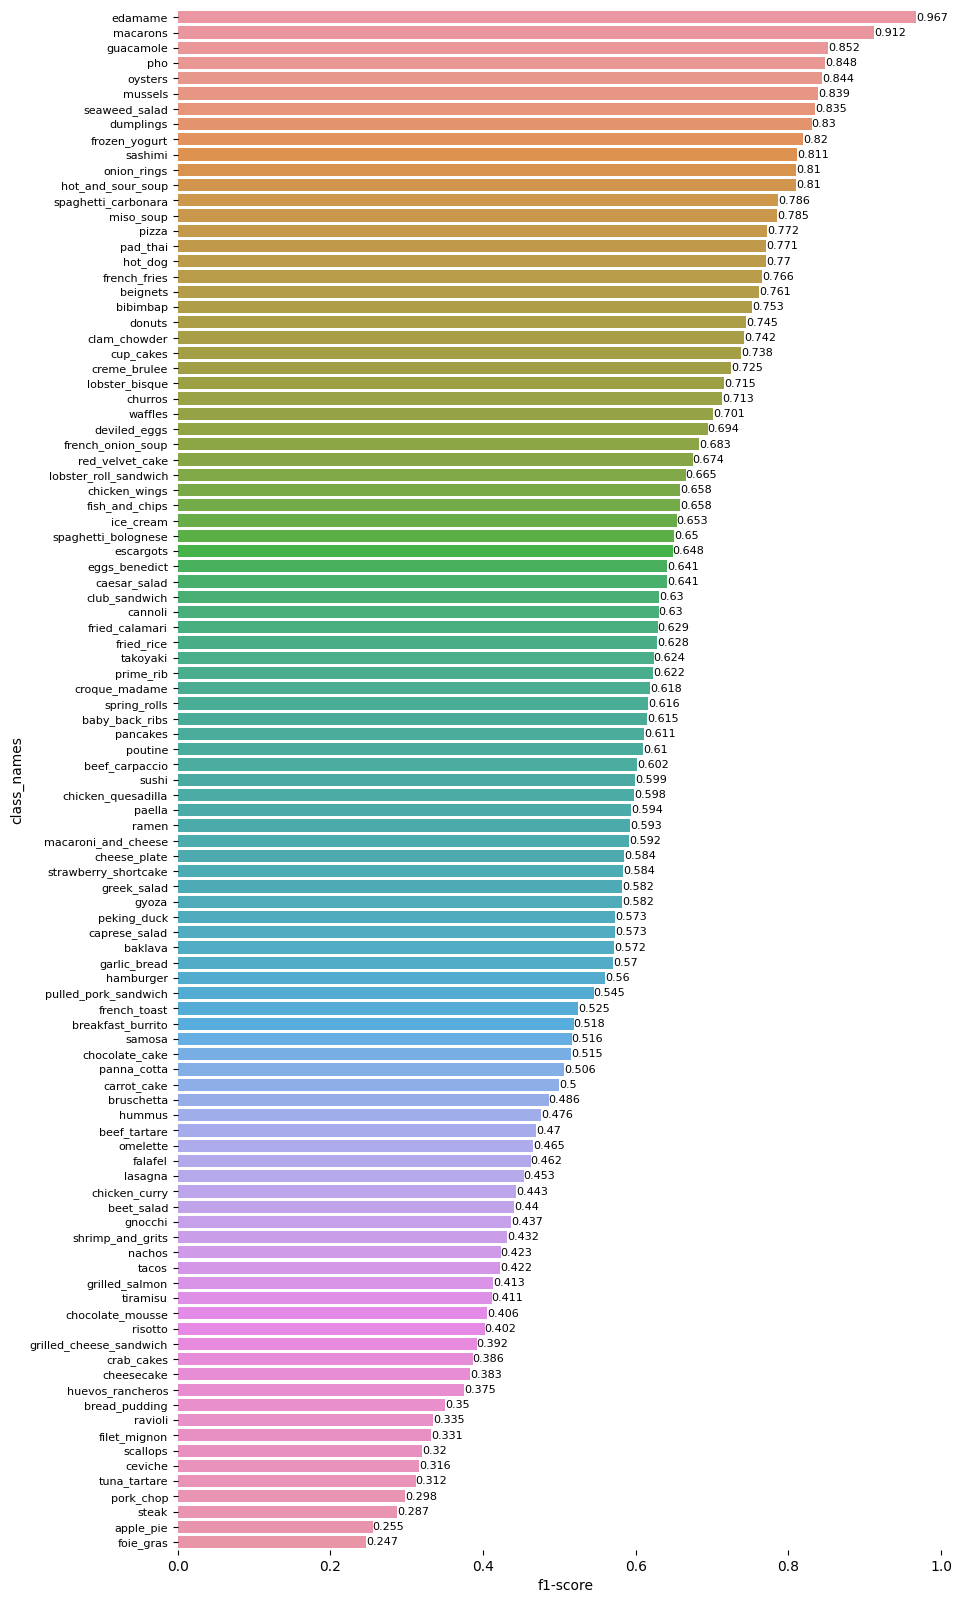

In [21]:
# visualizing the result
plt.figure(figsize=(10,20))

# we want a horizontal plot that's why we reverse the roles of x and y here.
sns.barplot(data=f1_scores_DataFrame,x='f1-score',y='class_names')

sns.despine(left=True,bottom=True)
plt.yticks(fontsize=8)


# annotate the bars with apt f1-scores
for index,value in enumerate(f1_scores_DataFrame['f1-score']):

  # notice that the value is the x axis and index is y axis here!
  plt.text(value,index,str(round(value,3)),ha='left',va='center',fontsize=8,color='black')


plt.show()

# conclusion:

**knowing where you are going wrong is the sure fire way to improve that area!!**

# make the model make predictions with custom images that we downlod from internet.


# steps:
1. read the target image file path using: tf.io.read_file().
2. turn the image into a tensor using: tf.io.decode_image().
3. turn the size of the image into the same size of the images our model has been trained on using: tf.image.resize().
4. scale the image to get all of its pixel values to range between 0 and 1.

In [22]:
def load_and_preprocess(filename,image_size,scale=False):

  """ any image can be proprocessed to become suitable for our model to predict on using this function

  Args:
  filename: this is the image file we download from the internet
  image_size: this is the size of the image the model has been trained on, so we have to convert the downloaded
              into model recognizable one
  scale: imagenetv2_b0 model doesn't need scaling but some models like resnet do in case of needing we will turn
         the boolean True
  """

  # read the file
  image = tf.io.read_file(filename)

  # convert the image into tensor (decode_image turns any image including jpeg,gif,png into tensors)
  # channels need to be specified as some images like png comes with 4 channels (RGBA A for alpha)
  image = tf.io.decode_image(image,channels=3)

  # resize the downloaded image into suitable size our model was trained on
  image = tf.image.resize(image,size=[image_size[0],image_size[1]])

  # scale when needed (not for efficient net models)
  if scale == True:
    image = image/255.

  # expand the dimension
  image = tf.expand_dims(image,axis=0)


  return image

# prediction on random images

1. take some `random` images from the test data
2. load and preprocess those images.
3. compare the truth label vs predicted label on the image side by side.

1/1 [==============================] - 0s 27ms/step


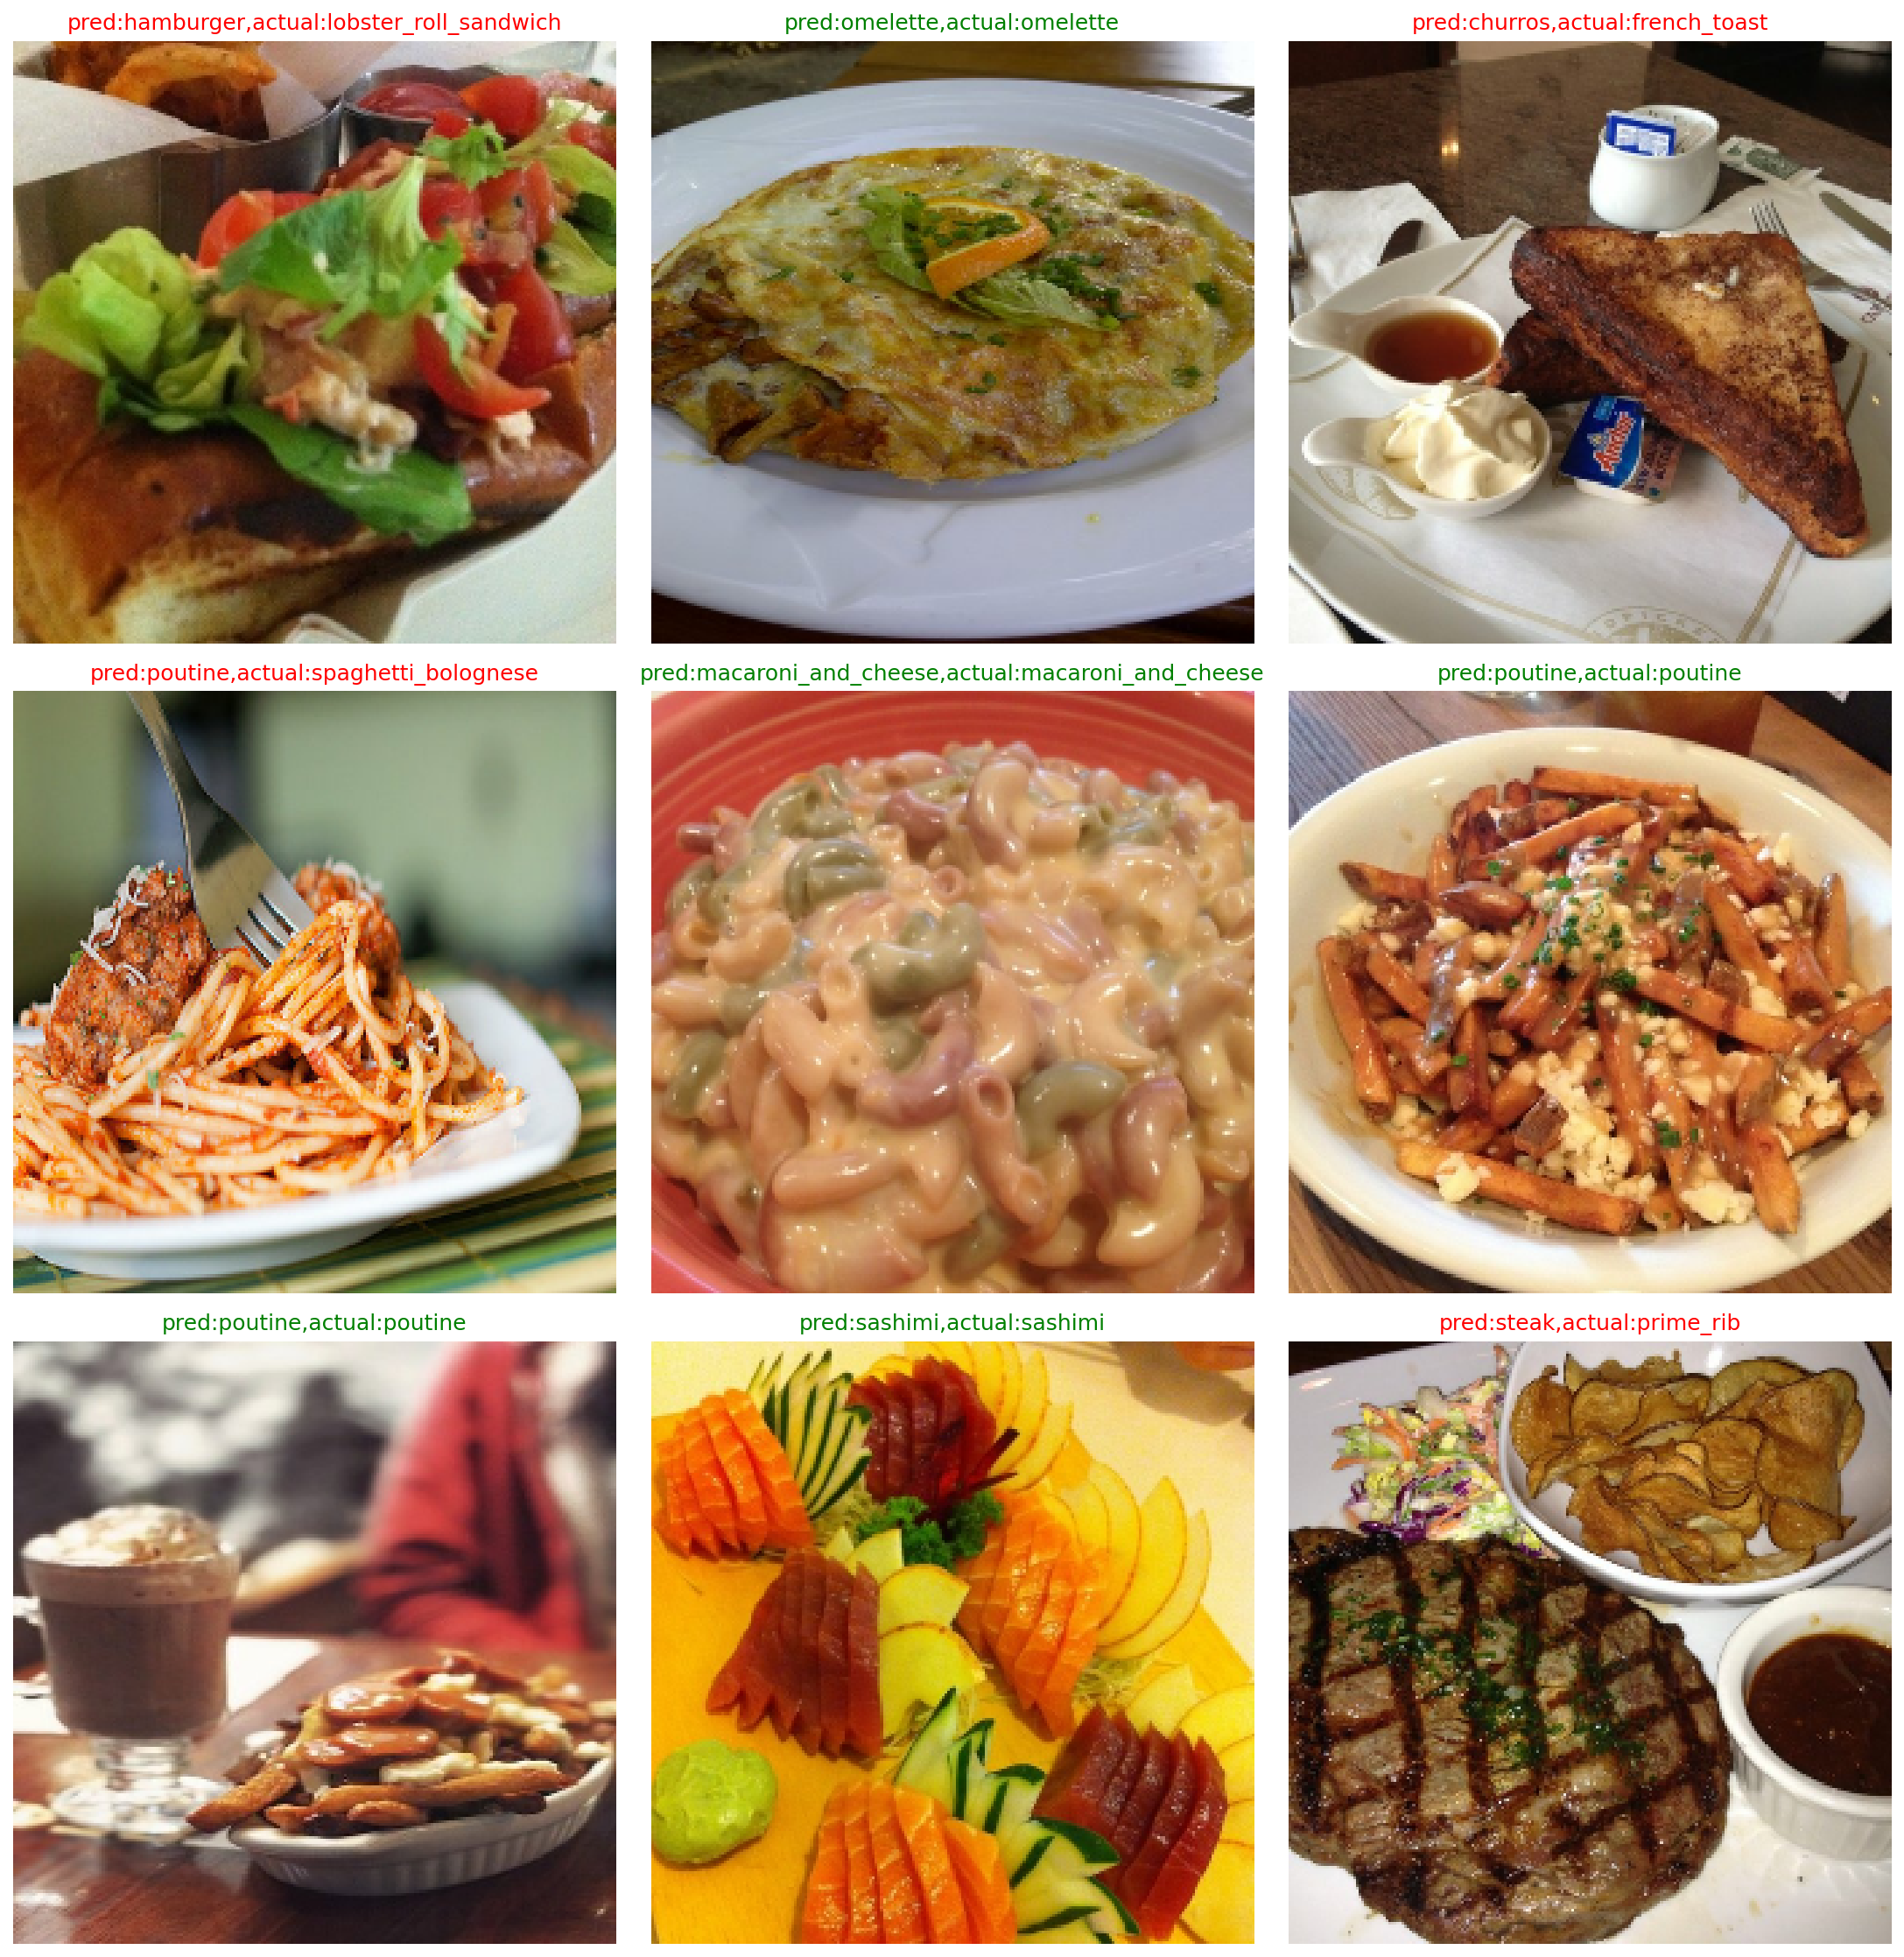

In [23]:
# get and show 3 predictions
plt.figure(dpi=150,figsize=(15,15))
for i in range(9):
  random_class_name = np.random.choice(class_names)
  random_image = np.random.choice(os.listdir(test_dir + '/' + random_class_name))
  filename = test_dir + '/' + random_class_name + '/' + random_image

  image = load_and_preprocess(filename,image_size=[224,224],scale=False)

  prediction = loaded_model0.predict(image).argmax(axis=1)[0]
  predicted_class_name = class_names[prediction]

  # show the images

  plt.subplot(3,3,i+1)
  # plt.imshow(im.imread(filename))
  plt.imshow(tf.squeeze(image)/255.) # squezzing the extra dimension and normalizing for matplotlib to show


  if random_class_name == predicted_class_name:
    title_color = 'g'
  else:
    title_color = 'r'

  plt.title('pred:{},actual:{}'.format(predicted_class_name,random_class_name),\
            color=title_color)
  plt.axis('off')
  plt.tight_layout()


plt.show()






# to find out where our model is most wrong!

# steps:
1. get the all the files in the test dataset using list_files() method.
2. create a pandas DataFrame comprising of actual classes,prediction classes, prediction probability.
3. use the DataFrame to find all the wrong predictions(where actual classes != prediction classes).
4. sort the DataFrame based on wrong predictions, make the prediction with highest probability come to the top.
5. visualize it using bar chart.

In [24]:
# get all of the image file paths from test_data

file_paths = []
for file_path in test_data.list_files(file_pattern='101_food_classes_10_percent/test/*/*.jpg',
                                      shuffle=False):
  file_paths.append(file_path.numpy())

file_paths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [25]:
# create the DataFrame that contains the filepath,actual_class,pred_class,pred_prob

pred_df = pd.DataFrame({'filepath':file_paths,'actual_class':actual_classes,'pred_class':pred_classes,
                        'pred_prob':predictions.max(axis=1),
                        'pred_class_name':[class_names[i] for i in pred_classes],
                        'actual_class_name':[class_names[i] for i in actual_classes]})

"""
What we have learnt newly here?
1. we now know that to calculate pre_prob first softmax it using tf.nn.softmax(predictions), then numpify it and then
find the max.
2. in dataframe also we can iterate and upload the contents using list comprehension.
"""
pred_df


,filepath,actual_class,pred_class,pred_prob,pred_class_name,actual_class_name
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,2,0.423992,baklava,apple_pie
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.645390,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.373638,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.243909,apple_pie,apple_pie
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.715143,bread_pudding,apple_pie
...,...,...,...,...,...,...
25245,b'101_food_classes_10_percent/test/waffles/942...,100,100,0.914100,waffles,waffles
25246,b'101_food_classes_10_percent/test/waffles/954...,100,100,0.977975,waffles,waffles
25247,b'101_food_classes_10_percent/test/waffles/961...,100,56,0.352570,huevos_rancheros,waffles
25248,b'101_food_classes_10_percent/test/waffles/970...,100,100,0.356383,waffles,waffles


In [26]:
# find where actual != pred but the pred_prob is the max. the goal is to remove/alter these pictures from the directory

boolean = pred_df['pred_class'] != pred_df['actual_class']
top_100_wrong = pred_df[boolean].sort_values('pred_prob',ascending=False)[:100]

top_100_wrong

,filepath,actual_class,pred_class,pred_prob,pred_class_name,actual_class_name
14482,b'101_food_classes_10_percent/test/hummus/8476...,57,51,0.994825,guacamole,hummus
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.994362,sashimi,sushi
17897,b'101_food_classes_10_percent/test/paella/2986...,71,65,0.993925,mussels,paella
17908,b'101_food_classes_10_percent/test/paella/3192...,71,65,0.993759,mussels,paella
10880,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.992467,onion_rings,fried_calamari
...,...,...,...,...,...,...
9755,b'101_food_classes_10_percent/test/foie_gras/1...,39,8,0.943148,bread_pudding,foie_gras
5829,b'101_food_classes_10_percent/test/churros/227...,23,68,0.942825,onion_rings,churros
19419,b'101_food_classes_10_percent/test/pork_chop/3...,77,37,0.942746,filet_mignon,pork_chop
24026,b'101_food_classes_10_percent/test/tacos/14531...,96,9,0.942746,breakfast_burrito,tacos


In [46]:
# visualize first 9 of these top_100_wrong images
rows = 3
cols = 3

start_index = 0
end_index = 9
plt.figure(figsize=(14,15))
image_address = list(top_100_wrong['filepath'][start_index:end_index]) # only 9 images
actual_class_names = list(top_100_wrong['actual_class_name'][start_index:end_index])
pred_class_names = list(top_100_wrong['pred_class_name'])[start_index:end_index]
pred_probs = list(top_100_wrong['pred_prob'])[start_index:end_index]

''' what have we learned? we learned that image.imread won't work on png files'''
for i in range(rows*cols):
  # get the image preprocessed
  image = load_and_preprocess(image_address[i],image_size=[224,224],scale=True)

  if pred_class_names[i] == actual_class_names[i]:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.subplot(rows,cols,i+1)
  plt.imshow(tf.squeeze(image))
  plt.title('actual:{}, \npred:{}'.format(actual_class_names[i],pred_class_names[i]),c=title_color)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel('probability:{:.3f}'.format(pred_probs[i]))


plt.show()



Output hidden; open in https://colab.research.google.com to view.

# making predictions with custom images downloaded/linked from internet

1/1 [==============================] - 0s 47ms/step


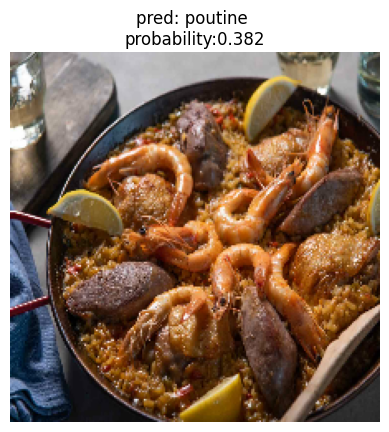

In [68]:
def pred_with_url(url):
  # url convertor to file is requests.get() only
  image = requests.get(url).content

  # decode the image to tensors with 3 channels(r,g,b)
  image = tf.io.decode_image(image)

  # resize the image to [224,224] the one our model was trained on
  image = tf.image.resize(image,size=[224,224])

  # add an extra dimension to compensate for the batch dimension with which the model was trained
  image = tf.expand_dims(image,axis=0)

  # make predictions
  prediction = loaded_model0.predict(image) # it has an inbuilt softmax-function

  # get the max of predictions for pred prob
  pred_prob = prediction.max(axis=1)[0]

  # get the prediction class
  pred_class = class_names[prediction.argmax(axis=1)[0]]

  # plot the image
  plt.imshow(tf.squeeze(image)/255.)
  plt.title('pred: {} \nprobability:{:.3f}'.format(pred_class,pred_prob))
  plt.axis('off')

  plt.show()

url = 'https://www.seriouseats.com/thmb/9NaZR_u6MatW1cBxR8jM9F2QrJo=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/__opt__aboutcom__coeus__resources__content_migration__serious_eats__seriouseats.com__2019__07__20190718-stovetop-paella-liz-clayman-19-9c241a28b1c54c5fadbfd6506063921f.jpg'

pred_with_url(url)


1/1 [==============================] - 0s 67ms/step


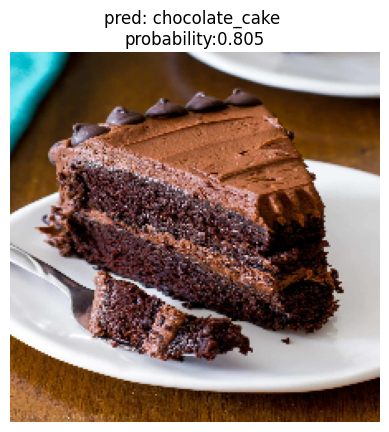

In [71]:
url = 'https://sallysbakingaddiction.com/wp-content/uploads/2013/04/triple-chocolate-cake-4.jpg'
pred_with_url(url)

1/1 [==============================] - 0s 43ms/step


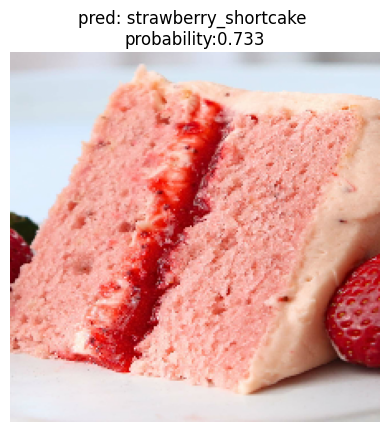

In [73]:
url = 'https://cakesbymk.com/wp-content/uploads/2023/08/Template-Size-for-Blog-Photos-46.jpg'
pred_with_url(url)

1/1 [==============================] - 0s 53ms/step


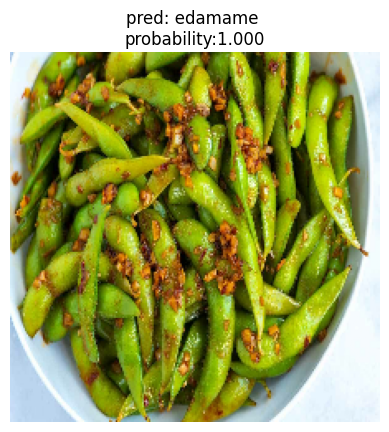

In [75]:
url = 'https://www.inspiredtaste.net/wp-content/uploads/2020/03/Spicy-Edamame-Recipe-1200.jpg'
pred_with_url(url)

1/1 [==============================] - 0s 60ms/step


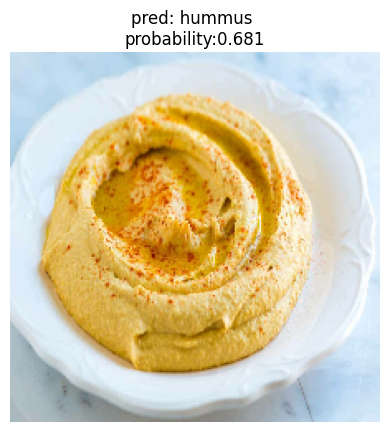

In [76]:
url = 'https://www.inspiredtaste.net/wp-content/uploads/2019/07/The-Best-Homemade-Hummus-Recipe-1200.jpg'
pred_with_url(url)

# exploration,analysis and freethrows